# Processing Marketdata Files

This notebook shows an example of processing a set of market data files into trades, quotes and open interest records using multiple processes to utilize all the cores on your machine.

It uses the marketdata_processor and pyqstrat_cpp submodules of pyqstrat.  pyqstrat_cpp contains functionality written in C++ since I use this for processing large tick data files, which can be hundreds of gigabytes and would take too long to process in Python.

Here are the stages we will go through.

1.  File discovery : Generating the list of files we need to process
2.  Decompressing and Reading Files : pyqstrat can handle gzip, bz2 and xz files
3.  Filtering: Discard any records we don't care about or that are clearly in error
3.  Parsing : Parsing lines from the file into quotes, trades or open interest records
4.  Cleaning : For example, some vendors use 0 to indicate there was no bid, we can replace it with NAN for easier downstream processing.
5.  Aggregation : Aggregate quotes and trades in various ways, for example, into 1 minute bars or into instantaneous top of book records and write these to disk.
6.  Writing: Finally we write the aggregated data to disk

## Test Data Creation

First, lets create some data.  We will create a few files in the temp directory representing data that a market data vendor would have sent us.  This data is options data formatted like Algoseek's options data files but the actual prices and quantities are not real.  We will create a gzipped file with some open interest, quote and trade records


,Timestamp,Ticker,Type,Side,Info,PutCall,Expiration,Strike,Quantity,Premium,Exchange
0,06:30:31.461,SPXW,O,,,C,20160316,21000000,1029,0,W
1,06:30:31.461,SPXW,O,,,P,20160316,20700000,5,0,W
2,06:30:31.461,SPXW,O,,,C,20160316,19750000,205,0,W
3,06:30:31.461,SPXW,O,,,C,20160316,19600000,320,0,W
4,06:30:31.461,SPXW,O,,,C,20160316,19450000,256,0,W
5,06:30:31.461,SPXW,O,,,C,20160316,19300000,9,0,W
6,06:30:31.461,SPXW,O,,,C,20160316,19150000,3,0,W
7,06:30:31.461,SPXW,O,,,C,20160316,19000000,253,0,W
8,06:30:31.461,SPXW,O,,,C,20160316,18850000,5,0,W
9,06:30:31.462,SPXW,O,,,P,20160316,18650000,194,0,W


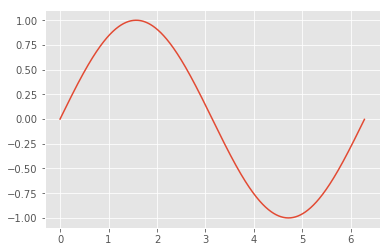

In [1]:
import pathlib
import pyqstrat as pq
import tempfile
import os

open_interest_records = \
b'''Timestamp,Ticker,Type,Side,Info,PutCall,Expiration,Strike,Quantity,Premium,Exchange
06:30:31.461,SPXW,O, , ,C,20160316,21000000,1029,0,W
06:30:31.461,SPXW,O, , ,P,20160316,20700000,5,0,W
06:30:31.461,SPXW,O, , ,C,20160316,19750000,205,0,W
06:30:31.461,SPXW,O, , ,C,20160316,19600000,320,0,W
06:30:31.461,SPXW,O, , ,C,20160316,19450000,256,0,W
06:30:31.461,SPXW,O, , ,C,20160316,19300000,9,0,W
06:30:31.461,SPXW,O, , ,C,20160316,19150000,3,0,W
06:30:31.461,SPXW,O, , ,C,20160316,19000000,253,0,W
06:30:31.461,SPXW,O, , ,C,20160316,18850000,5,0,W
06:30:31.462,SPXW,O, , ,P,20160316,18650000,194,0,W
06:30:31.463,SPXW,O, , ,P,20160316,18350000,722,0,W
06:30:31.463,SPXW,O, , ,P,20160316,18200000,204,0,W
06:30:31.463,SPXW,O, , ,C,20160316,20450000,690,0,W
06:30:31.463,SPXW,O, , ,P,20160316,20250000,498,0,W
06:30:31.463,SPXW,O, , ,C,20160316,20050000,559,0,W
06:30:31.464,SPXW,O, , ,C,20160316,19900000,530,0,W
'''

quote_records = \
b'''10:19:12.950,BRKA,F,O, ,C,20160316,20450000,115,15500,W
10:19:13.140,BRKA,F,O, ,C,20160316,20300000,85,49000,W
10:19:13.140,BRKA,F,B, ,C,20160316,20300000,38,45000,W
10:19:13.140,BRKA,F,O, ,C,20160316,20350000,87,34000,W
10:19:13.140,BRKA,F,B, ,C,20160316,20350000,44,31000,W
10:19:13.140,BRKA,F,O, ,C,20160316,20100000,48,143000,W
10:19:13.140,BRKA,F,B, ,C,20160316,20100000,30,136000,W
10:19:13.141,BRKA,F,O, ,P,20160316,20150000,32,120000,W
10:19:13.141,BRKA,F,B, ,P,20160316,20150000,55,112000,W
10:19:13.141,BRKA,F,O, ,P,20160316,20050000,51,78000,W
10:19:13.141,BRKA,F,B, ,P,20160316,20050000,28,73000,W
10:19:13.141,BRKA,F,O, ,P,20160316,20250000,14,175000,W
10:19:13.141,BRKA,F,B, ,P,20160316,20250000,21,161000,W
10:19:13.141,BRKA,F,O, ,P,20160316,20200000,15,145000,W
10:19:13.141,BRKA,F,B, ,P,20160316,20200000,42,136000,W
10:20:13.152,BRKA,F,O, ,C,20160316,20050000,24,179000,W
10:20:13.152,BRKA,F,B, ,C,20160316,20450000,18,165000,W
10:20:13.152,BRKA,F,O, ,C,20160316,20300000,85,49000,W
10:20:13.152,BRKA,F,B, ,C,20160316,20300000,28,45000,W
10:20:13.160,BRKA,F,O, ,C,20160316,20100000,52,143000,W
10:20:13.160,BRKA,F,B, ,C,20160316,20100000,30,136000,W
10:20:13.161,BRKA,F,O, ,C,20160316,20300000,85,49000,W
10:20:13.161,BRKA,F,B, ,C,20160316,20300000,32,45000,W
10:20:13.161,BRKA,F,O, ,P,20160316,20050000,55,78000,W
10:20:13.161,BRKA,F,B, ,P,20160316,20050000,28,73000,W
10:20:13.161,BRKA,F,O, ,P,20160316,20100000,20,96000,W
10:20:13.161,BRKA,F,B, ,P,20160316,20100000,48,91000,W
10:20:13.161,BRKA,F,O, ,P,20160316,20150000,36,120000,W
10:20:13.161,BRKA,F,B, ,P,20160316,20150000,59,112000,W
'''

trade_records = \
b'''09:30:03.365,BRKA,T, , ,C,20160316,20200000,1,98000,W
09:30:03.481,BRKA,T, , ,P,20160316,20650000,2,442000,W
09:30:03.566,BRKA,T, ,L,P,20160316,20650000,1,6000,W
09:30:03.568,BRKA,T, ,L,P,20160316,20650000,2,13500,W
09:30:03.568,BRKA,T, ,L,P,20160316,19900000,1,34000,W
09:30:04.473,BRKA,T, ,L,C,20160316,19450000,15,714000,W
09:30:05.883,BRKA,T, ,L,C,20160316,20400000,4,24000,W
09:30:05.884,BRKA,T, ,L,P,20160316,20100000,10,87500,W
09:30:05.884,BRKA,T, ,L,P,20160316,20150000,10,109000,W
09:30:05.886,BRKA,T, ,L,C,20160316,20150000,3,119000,W
09:30:05.886,BRKA,T, ,L,C,20160316,20550000,3,7000,W
09:30:05.886,BRKA,T, ,L,P,20160316,19750000,3,15000,W
09:30:05.886,BRKA,T, ,L,P,20160316,20150000,3,110500,W
09:31:09.285,BRKA,T, ,L,P,20160316,20650000,10,26000,W
09:31:09.286,BRKA,T, ,L,P,20160316,20650000,10,33500,W
09:31:11.491,BRKA,T, , ,P,20160316,20650000,24,28000,W
09:31:11.586,BRKA,T, , ,P,20160316,19850000,12,28000,W
09:31:12.805,BRKA,T, , ,P,20160316,19800000,34,22000,W
09:31:12.831,BRKA,T, , ,P,20160316,19750000,44,17500,W
09:31:12.863,BRKA,T, , ,P,20160316,19750000,13,17500,W
09:31:13.640,BRKA,T, , ,P,20160316,19850000,1,28000,W
09:31:18.232,BRKA,T, ,L,C,20160316,20350000,26,34000,W
09:31:18.232,BRKA,T, ,L,C,20160316,20400000,26,23000,W
09:31:19.176,BRKA,T, ,L,P,20160316,19200000,3,3000,W
09:31:19.176,BRKA,T, ,L,P,20160316,19300000,3,3500,W
09:31:21.639,BRKA,T, ,L,C,20160316,20350000,4,34000,W
'''

other_records = \
b'''09:30:03.566,BRKA, , ,Sample Info,P,20160316,19500000,,,W
09:30:03.568,BRKA,X, ,Sample Info 2,P,20160316,19700000,,,W
09:30:05.886,BRKA,X, ,Sample Info 3,C,20160316,20550000,,,W
09:30:05.886,BRKA,X, ,Sample Info 4,P,20160316,19750000,,,W
09:30:05.886,BRKA,X, ,Sample Info 5,P,20160316,20150000,,,W
'''
if os.path.isdir('/tmp'):
    temp_dir = "/tmp/"
else:
    temp_dir =  tempfile.gettempdir()
    
input_filename = temp_dir + '/BRKA_2018-01-01_data'
    
from sys import platform
if platform not in ["win32", "cygwin"]: # cannot read compressed files on windows yet because of link issues with boost
    input_filename += '.gz'
    import gzip
    with gzip.open(input_filename, 'wb') as f:
        f.write(open_interest_records + quote_records + trade_records + other_records)
else:
    with open(input_filename, 'w') as f:
        f.write((open_interest_records + quote_records + trade_records + other_records).decode('utf-8'))
    
# Look at the data
import pandas as pd
pd.read_csv(input_filename)

## File discovery

We use the helper function object PathFileNameProvider to generate the list of files we need to process.  We then use the helper function object  
SingleDirectoryFileNameMapper to figure out the output file name corresponding to each input file.  We will write output files with the same prefix
as their corresponding input files but in a subdirectory called pyqstrat



In [2]:
file_path = temp_dir + '/BRKA_*'

if platform not in ["win32", "cygwin"]: # cannot read compressed files on windows yet because of link issues with boost
    file_path += '.gz'

input_filename_provider = pq.PathFileNameProvider(file_path)
output_dir = temp_dir + '/pyqstrat'
if not os.path.isdir(output_dir): os.mkdir(output_dir)
output_file_prefix_mapper = pq.SingleDirectoryFileNameMapper(output_dir)

## Filtering
Lets first create the functions that let us know if a record is a trade, quote or open interest record.  We know the second field in the input file contains the type of record.  We will also create a function that will let us quickly discard any lines we don't care about before we start parsing them.  We can also use a record filter that will filter out trade records after they have been parsed for more fine grained filtering, but we don't need it here, so we let the record filter default to None.

We implement IsOther differently than the other functions to show how we can write a function in Python and plug it into the processing instead of using the predefined C++ functions. This will be much slower than using C++ functions so avoid using frequently called Python functions in production.

In [3]:
is_quote = pq.IsFieldInList(2, ["F", "N"])
is_trade = pq.IsFieldInList(2, ["T"])
is_open_interest = pq.IsFieldInList(2, ["O"])

# Show how a function can be implemented in python instead of using the pyqstrat C++ predefined functions
class PyIsFieldInList(pq.CheckFields):
    # The following line is necessary due to the way pybind11 calls virtual functions.  
    # See #https://pybind11.readthedocs.io/en/stable/advanced/classes.html
    def __init__(self, field_idx, flags):
        pq.CheckFields.__init__(self) 
        self.field_idx = field_idx
        self.flags = flags
        
    def __call__(self, fields):
        return fields[self.field_idx] in self.flags
    
is_other = PyIsFieldInList(2, ["X"])

# Keep only the lines that contain one of these substrings.  We can also use pq.RegExLineFilter but that is much slower than checking for substrings
line_filter = pq.SubStringLineFilter([",T,", ",F,", ",N,", ",O,", ",X,"])

## Parsing

Lets now create functions that create parsers.  We are going to use the helper function objects TextQuoteParser, TextTradeParser, TextOpenInterestParser, TextOtherParser that create the corresponding types from a record in the file.  These are designed for compressed or uncompressed text files where price, qty, etc. are stored in delimited fields.  If that is not the case for your market data files, you will have to create your own parsers.  These function objects are written in C++ for performance.

We use the helper function FixedWidthParser which parses timestamps that have a fixed place for years, months, days, hours, minutes, seconds, milliseconds or microsedonds

By default the system uses the helper function object PrintBadLineHandler for records that cannot be parsed.  This class prints out unparseable lines for debugging, or raises an Exception, depending on how its initialized.  You can implement your own handler for second chance, slower parsing of more complex records.

By default, the sytem also uses the helper function price_qty_missing_data_handler to set prices and quantities that are 0 to NAN.  You can implement your own function object for other policies to deal with missing data.

In [4]:
time_parser = pq.FixedWidthTimeParser(micros = False, hours_start = 0, hours_size = 2, minutes_start = 3, minutes_size = 2, seconds_start = 6, seconds_size = 2, 
                                     millis_start = 9, millis_size = 3)

def create_quote_parser(base_date, headers):
    timestamp_idx = headers.index('timestamp')
    qty_idx = headers.index('quantity')
    price_idx = headers.index('premium')
    bid_offer_idx = headers.index('side')
    # Id indices are used to uniquely identify an instrument.  Within this file, put/call, epxiry and strike uniquely identify an option
    id_indices = pq.get_field_indices(['putcall', 'expiration', 'strike'], headers)
    # Any other info besides qty, price, bid/offer and id that we want to store is stored in the meta field
    meta_indices = pq.get_field_indices(['info', 'exchange'], headers)
    # Prices in the input file are stored in thousands of cents so we divide them by 10000.0 to get dollars.
    # Bids are stored as "O" and offers are stored as "O"
    return pq.TextQuoteParser(is_quote, base_date, [timestamp_idx], bid_offer_idx, price_idx, qty_idx, id_indices, meta_indices,
                              [time_parser], "B", "O", 10000.0)
                                 
def create_trade_parser(base_date, headers):
    timestamp_idx = headers.index('timestamp')
    qty_idx = headers.index('quantity')
    price_idx = headers.index('premium')
    id_indices = pq.get_field_indices(['putcall', 'expiration', 'strike'], headers)
    meta_indices = pq.get_field_indices(['info', 'exchange'], headers)
    return pq.TextTradeParser(is_trade, base_date, [timestamp_idx], price_idx, qty_idx, id_indices, meta_indices,
                                    [time_parser], 10000.0)
                                 
def create_open_interest_parser(base_date, headers):
    timestamp_idx = headers.index('timestamp')
    qty_idx = headers.index('quantity')
    id_indices = pq.get_field_indices(['putcall', 'expiration', 'strike'], headers)
    meta_indices = pq.get_field_indices(['info', 'exchange'], headers)
    return pq.TextOpenInterestParser(is_open_interest, base_date, [timestamp_idx], qty_idx, id_indices, meta_indices,
                                    [time_parser], 10000.0)
                           
def create_other_parser(base_date, headers):
    timestamp_idx = headers.index('timestamp')
    qty_idx = headers.index('quantity')
    id_indices = pq.get_field_indices(['putcall', 'expiration', 'strike'], headers)
    meta_indices = pq.get_field_indices(['info', 'exchange'], headers)
    return pq.TextOtherParser(is_other, base_date, [timestamp_idx], id_indices, meta_indices, [time_parser])
    
def create_record_parser(base_date, headers):
    
    return pq.TextRecordParser([create_quote_parser(base_date, headers), 
                                create_trade_parser(base_date, headers), 
                                create_open_interest_parser(base_date, headers), 
                                create_other_parser(base_date, headers)], 
                               exclusive = False)
        

## Aggregation

We have a choice on how we want to aggregate these records.  We will use the helper class QuoteTOBAggregator which creates top-of-book quotes at a given frequency (or for all ticks if frequency is omitted) and TradeBarAggregator which creates trade bars at given freqency.  For Open Interest and OtherRecords, we keep all records.  You can use None for any of these functions if you only care about parsing Trades, for example.

In [5]:
def create_aggregators(writer_creator, output_file_prefix, frequency = '1m'):
    return [pq.QuoteTOBAggregator(writer_creator, output_file_prefix + ".tob", frequency = frequency),
            pq.TradeBarAggregator(writer_creator, output_file_prefix + ".trades", frequency = frequency),
            pq.AllOpenInterestAggregator(writer_creator, output_file_prefix + ".open_interest"),
            pq.AllOtherAggregator(writer_creator, output_file_prefix + ".other")]

## Writing

By default pyqstrat writes files using Apache Arrow so we can quickly read them back in Python without having to do any type conversion, or imply datatypes.  You can change the writing format by setting the argument writer_creator to a function that creates your own class implementing the pyqstrat Writer interface.  

Writers write data in batches.  This allows us to be able to read a set of records that fit in memory by reading a batch of records at a time.  The Trade and Quote Aggregators allow you to either create one batch per id or set a batch size.  Use the former when you are aggregating to a relatively small data set.  For example, if you are writing out 5 minute bars, chances are you can process a large input file without overwhelming memory.  In this case, the Arrow Writer also writes out a separate file that maps each instrument id to its corresponding batch.  

If you need to record every tick, you might want to use the latter approach,  which will write out a batch to disk as soon as the aggregators have processed a certain number of records.

## Finishing Up

We are now ready to run the process.  

In [6]:
def process(input_filename):
    pq.process_marketdata_file(input_filename,
             output_file_prefix_mapper, 
             create_record_parser,
             create_aggregators,
             line_filter)
    
if __name__ == "__main__":
    # arrow writer creates an empty *.done marker file to indicate when its finished processing an input file, delete it so we can rerun
    done_file = output_dir + '/BRKA_2018-01-01_data.done'
    if os.path.exists(done_file): os.remove(done_file)
    with pq.ostream_redirect(stdout = True, stderr = True):
        pq.process_marketdata(input_filename_provider, process, num_processes = 8)
        
def run_me():
    # arrow writer creates an empty *.done marker file to indicate when its finished processing an input file, delete it so we can rerun
    done_file = output_dir + '/BRKA_2018-01-01_data.done'
    if os.path.exists(done_file): os.remove(done_file)
    with pq.ostream_redirect(stdout = True, stderr = True):
        pq.process_marketdata(input_filename_provider, process, num_processes = 8)

  

starting file: /tmp/BRKA_2018-01-01_data.gz
processing file: /tmp/BRKA_2018-01-01_data.gz process id: 8171
finished file: /tmp/BRKA_2018-01-01_data.gz
processed: /tmp/BRKA_2018-01-01_data.gz 77 lines in 9 milliseconds


We can now look at the output files using the Apache Arrow libraries

In [7]:
import pyarrow as pa

In [8]:
pa.RecordBatchFileReader(pa.OSFile(output_dir + '/BRKA_2018-01-01_data.open_interest.arrow', 'r')).read_pandas()

/anaconda3/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,line_num,id,timestamp,qty,meta
0,2,C|20160316|21000000,1970-01-01 06:30:31.461,1029,|W
1,3,P|20160316|20700000,1970-01-01 06:30:31.461,5,|W
2,4,C|20160316|19750000,1970-01-01 06:30:31.461,205,|W
3,5,C|20160316|19600000,1970-01-01 06:30:31.461,320,|W
4,6,C|20160316|19450000,1970-01-01 06:30:31.461,256,|W
5,7,C|20160316|19300000,1970-01-01 06:30:31.461,9,|W
6,8,C|20160316|19150000,1970-01-01 06:30:31.461,3,|W
7,9,C|20160316|19000000,1970-01-01 06:30:31.461,253,|W
8,10,C|20160316|18850000,1970-01-01 06:30:31.461,5,|W
9,11,P|20160316|18650000,1970-01-01 06:30:31.462,194,|W


In [9]:
pa.RecordBatchFileReader(pa.OSFile(output_dir + '/BRKA_2018-01-01_data.trades.1m.arrow', 'r')).read_pandas()

,line_num,id,timestamp,last_update,o,h,l,c,v,vwap
0,52,C|20160316|19450000,1970-01-01 09:31:00,1970-01-01 09:30:04.473,71.400002,71.400002,71.400002,71.400002,15,71.400002
1,56,C|20160316|20150000,1970-01-01 09:31:00,1970-01-01 09:30:05.886,11.9,11.9,11.9,11.9,3,11.899999
2,47,C|20160316|20200000,1970-01-01 09:31:00,1970-01-01 09:30:03.365,9.8000002,9.8000002,9.8000002,9.8000002,1,9.8000002
3,72,C|20160316|20350000,1970-01-01 09:32:00,1970-01-01 09:31:21.639,3.4000001,3.4000001,3.4000001,3.4000001,4,3.4000001
4,53,C|20160316|20400000,1970-01-01 09:31:00,1970-01-01 09:30:05.883,2.4000001,2.4000001,2.4000001,2.4000001,4,2.4000001
5,69,C|20160316|20400000,1970-01-01 09:32:00,1970-01-01 09:31:18.232,2.3,2.3,2.3,2.3,26,2.3
6,57,C|20160316|20550000,1970-01-01 09:31:00,1970-01-01 09:30:05.886,0.69999999,0.69999999,0.69999999,0.69999999,3,0.69999999
7,70,P|20160316|19200000,1970-01-01 09:32:00,1970-01-01 09:31:19.176,0.30000001,0.30000001,0.30000001,0.30000001,3,0.30000001
8,71,P|20160316|19300000,1970-01-01 09:32:00,1970-01-01 09:31:19.176,0.34999999,0.34999999,0.34999999,0.34999999,3,0.34999999
9,58,P|20160316|19750000,1970-01-01 09:31:00,1970-01-01 09:30:05.886,1.5,1.5,1.5,1.5,3,1.5


In [10]:
pa.RecordBatchFileReader(pa.OSFile(output_dir + '/BRKA_2018-01-01_data.tob.1m.arrow', 'r')).read_pandas()

,line_num,id,timestamp,last_update,bid,bid_size,ask,ask_size
0,33,C|20160316|20050000,1970-01-01 10:21:00,1970-01-01 10:20:13.152,nan,nan,17.9,24
1,24,C|20160316|20100000,1970-01-01 10:20:00,1970-01-01 10:19:13.140,13.6,30,14.3,48
2,38,C|20160316|20100000,1970-01-01 10:21:00,1970-01-01 10:20:13.160,13.6,30,14.3,52
3,20,C|20160316|20300000,1970-01-01 10:20:00,1970-01-01 10:19:13.140,4.5,38,4.9000001,85
4,40,C|20160316|20300000,1970-01-01 10:21:00,1970-01-01 10:20:13.161,4.5,32,4.9000001,85
5,22,C|20160316|20350000,1970-01-01 10:20:00,1970-01-01 10:19:13.140,3.0999999,44,3.4000001,87
6,18,C|20160316|20450000,1970-01-01 10:20:00,1970-01-01 10:19:12.950,nan,nan,1.55,115
7,34,C|20160316|20450000,1970-01-01 10:21:00,1970-01-01 10:20:13.152,16.5,18,1.55,115
8,28,P|20160316|20050000,1970-01-01 10:20:00,1970-01-01 10:19:13.141,7.3000002,28,7.8000002,51
9,42,P|20160316|20050000,1970-01-01 10:21:00,1970-01-01 10:20:13.161,7.3000002,28,7.8000002,55


In [11]:
pa.RecordBatchFileReader(pa.OSFile(output_dir + '/BRKA_2018-01-01_data.other.arrow', 'r')).read_pandas()

,line_num,id,timestamp,meta
0,74,P|20160316|19700000,1970-01-01 09:30:03.568,Sample Info 2|W
1,75,C|20160316|20550000,1970-01-01 09:30:05.886,Sample Info 3|W
2,76,P|20160316|19750000,1970-01-01 09:30:05.886,Sample Info 4|W
3,77,P|20160316|20150000,1970-01-01 09:30:05.886,Sample Info 5|W
